## Otázky na které hledáme odpovědi

- Jaká je přirozená míra proměnlivosti počasí v daném místě? Jaké teploty jsou pro dané období v roce běžné a jaké výjimečné?
- Jak se mění klimatické podmínky v průběhu klimatické změny – tedy jak se mění co je běžné a co je výjimečné počasí? Jak se mění frekvence výskytu neobvykle teplých a nebvykle chladných dní?
- Jak srovnávat extrémní události (vedra, zimy) s jinými místy na planetě? Jinak řečeno: lze srovnat variability klimatu třeba s Kanadou, Jižní Afrikou, nebo Singapurem? Když bylo v Kanadě naměřeno +50 °C – jaký teplotní extrém by tomu odpovídal u nás?
- Jaké klimatické podmínky můžeme očekávat v budoucnosti – zejména co se týče výskytu extrémně teplých dní?
- Jak atribuovat extrémy ke klimatické změně?

## Definice veličin

Jako vstupní data máme průměrné denní teploty, nejvyšší denní teploty a nejnižší denní teploty pro určité místo – $T(s, y, d)$, $T_{\rm max}(s, y, d)$, $T_{\rm min}(s, y, d)$, kde $s$ označuje stanici, $y$ rok měření a $d$ den v roce.

**Teplotní normál** (TN) pro dané místo a den je aritmetický průměr teplot daného dne v referenčním období, v našem případě v letech 1961–1980:
$$
\begin{align*}
TN(s, d) &= \frac{1}{20} \sum_{y=1961}^{1980} T(s, y, d) \quad\text{je normál průměrné denní teploty,} \\
TN_{\rm max}(s, d) &= \frac{1}{20} \sum_{y=1961}^{1980} T_{\rm max}(s, y, d) \quad\text{je normál nejvyšší denní teploty,} \\
TN_{\rm min}(s, d) &= \frac{1}{20} \sum_{y=1961}^{1980} T_{\rm min}(s, y, d) \quad\text{je normál nejnižší denní teploty.}
\end{align*}
$$

**Teplotní odchylka** (teplotní anomálie, TA) pro dané místo a den je rozdíl naměřené hodnoty od normálu daného dne. Teplotní odchylky opět definujeme pro průměry, maxima i minima:
$$
\def\TA{T\!A}
\begin{align*}
\TA(s, y, d) &= T(s, y, d) - TN(s, d) \\
\TA_{\rm max}(s, y, d) &= T_{\rm max}(s, y, d) - TN_{\rm max}(s, d) \\
\TA_{\rm min}(s, y, d) &= T_{\rm min}(s, y, d) - TN_{\rm min}(s, d)
\end{align*}
$$

Nicméně protože se ukazuje, že mezi $\TA$, $\TA_{\rm max}$ a $\TA_{\rm min}$ je velmi silná korelace, používáme dále pro kvantifikaci variability klimatu pouze $\TA$.

In [ ]:
library(assertthat)
library(patchwork)
library(tidyverse)

theme_set(theme_minimal())
options(repr.plot.res = 200)

DATA_SOURCE_URL <- "https://www.envidata.cz/projects/faktaOKlimatu/export.php?type=raw&ID="
# Identifikátory vybraných stanic ČHMÚ.
STATION_IDS     <- c(
  "Brno-Tuřany" = "B2BTUR01",
  "Liberec"     = "U2LIBC01",
  "Lysá hora"   = "O1LYSA01",
  "Klementinum" = "P1PKLE01",
  "Ruzyně"      = "P1PRUZ01",
  "Přibyslav"   = "P3PRIB01"
)
# Barva průměrných, maximálních a minimálních teplot v následujících grafech.
COLOUR_TAVG     <- "grey40"
COLOUR_TMAX     <- "tomato3"
COLOUR_TMIN     <- "dodgerblue3"

# Rozsah let, pro která se načtou data (včetně).
data_period <- c(1961, 2020)
# Rozsah let referenčního období (včetně).
ref_period  <- c(1961, 1980)

# Zkratky měsíců v českém jazyce.
month.abb <- stringi::stri_datetime_symbols("cs_CZ", width = "abb")$Month
# Délky jednotlivých měsíců v (přestupném) roce.
month.len <- c(31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)

# Funkce pro stažení a uložení dat ze stanice ve formátu CSV.
download_and_cache <- function(station_id) {
  file_path <- paste0("../data/chmi/", station_id, ".csv")
  if (!file.exists(file_path)) {
    url <- paste0(DATA_SOURCE_URL, station_id)
    download.file(url, file_path, quiet = TRUE)
  }
  read_csv(file_path, show_col_types = FALSE) |>
    transmute(date       = lubridate::ymd(paste(Y, M, D, sep = "-")),
              ix         = lubridate::yday(date),
              year       = Y,
              month      = M,
              day        = D,
              tavg       = TAVG,
              tmax       = TMAX,
              tmin       = TMIN,
              station_id = station_id)
}

In [2]:
# Načtení and předfiltrování dat.
daily_weather <- map_dfr(STATION_IDS, download_and_cache) |>
  filter(data_period[1] <= year, year <= data_period[2])

# Výpočet prostých a vyhlazených normálů pro každý den v referenčním období.
daily_normals <- daily_weather |>
  filter(ref_period[1] <= year, year <= ref_period[2]) |>
  group_by(station_id, month, day) |>
  summarise(normal_avg = mean(tavg),
            normal_max = mean(tmax),
            normal_min = mean(tmin),
            .groups    = "drop")

In [3]:
# Výpočet denních teplotních anomální pro průměrnou, minimální a maximální teplotu.
daily_anomalies <- daily_weather |>
  inner_join(daily_normals, by = c("station_id", "month", "day")) |>
  mutate(anomaly_avg = tavg - normal_avg,
         anomaly_max = tmax - normal_max,
         anomaly_min = tmin - normal_min,
         period      = cut(year, c(1960, 1980, 2000, 2020),
                           labels = c("1961–1980", "1981–2000", "2001–2020")))

assert_that(are_equal(nrow(daily_weather), nrow(daily_anomalies)))

[1] TRUE

## Extrémy ve vybrané dny

V této sekci se zaměříme na teplotní maxima v určitý den na třech různých stanicích: silvestry (31. prosince) v Praze-Ruzyni a letní slunovraty (21. červny) v Brně-Tuřanech a na Lysé hoře.

Následující graf ukazuje rozložení maximálních denních teplot v tyto dny na těchto stanicích.

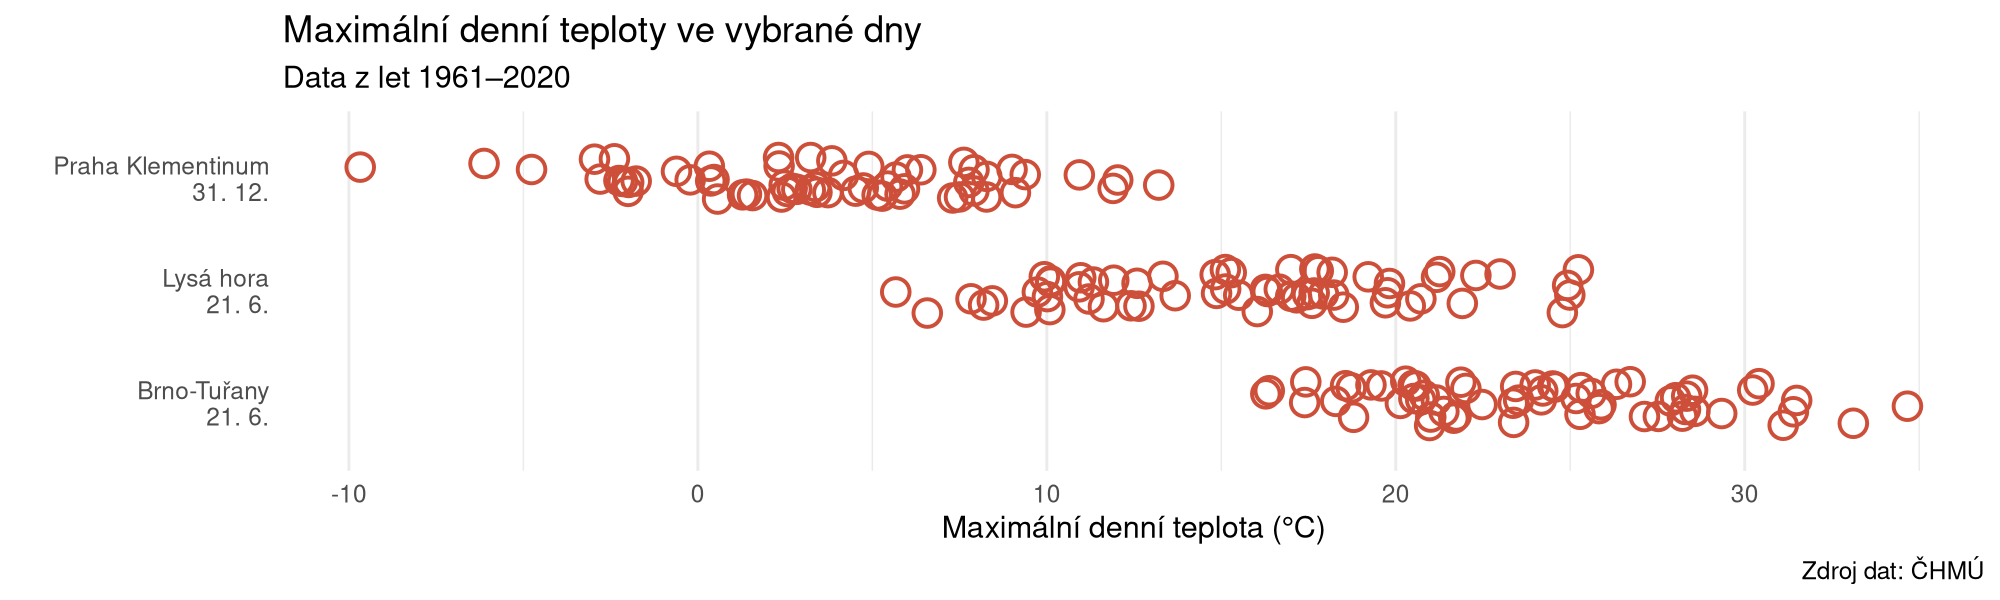

In [4]:
selected_anomalies <- daily_anomalies |>
  filter((station_id == "P1PKLE01" & month == 12 & day == 31) |
          (station_id %in% c("B2BTUR01", "O1LYSA01") & month == 6 & day == 21))

options(repr.plot.width = 10, repr.plot.height = 3)
ggplot(selected_anomalies, aes(x = tmax, y = station_id)) +
  geom_jitter(colour = COLOUR_TMAX, height = .2, shape = 1, size = 4, stroke = 1) +
  scale_y_discrete(labels = c("Brno-Tuřany\n21. 6.",
                              "Lysá hora\n21. 6.",
                              "Praha Klementinum\n31. 12.")) +
  labs(x        = "Maximální denní teplota (°C)",
       y        = "",
       title    = "Maximální denní teploty ve vybrané dny",
       subtitle = glue::glue("Data z let {data_period[1]}–{data_period[2]}"),
       caption  = "Zdroj dat: ČHMÚ") +
  theme(panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank())

In [5]:
group_by(selected_anomalies, station_id) |>
  summarise(normal_max = first(normal_max)) |>
  mutate(across(where(is.numeric), ~ round(.x, 1)))

station_id,normal_max
<chr>,<dbl>
B2BTUR01,22.8
O1LYSA01,14.4
P1PKLE01,2.3


V Brně-Tuřanech je teplotní normál pro maxima 21. června 22,8 °C. Na Lysé hoře je normál pro stejný den 14,4 °C. Silvestrovský normál pro maxima je v Klementinu 2,3 °C.

## Teplé dny

Následující graf ukazuje nárůst počtu neobvykle teplých dní na příkladu stanice Brno-Tuřany.

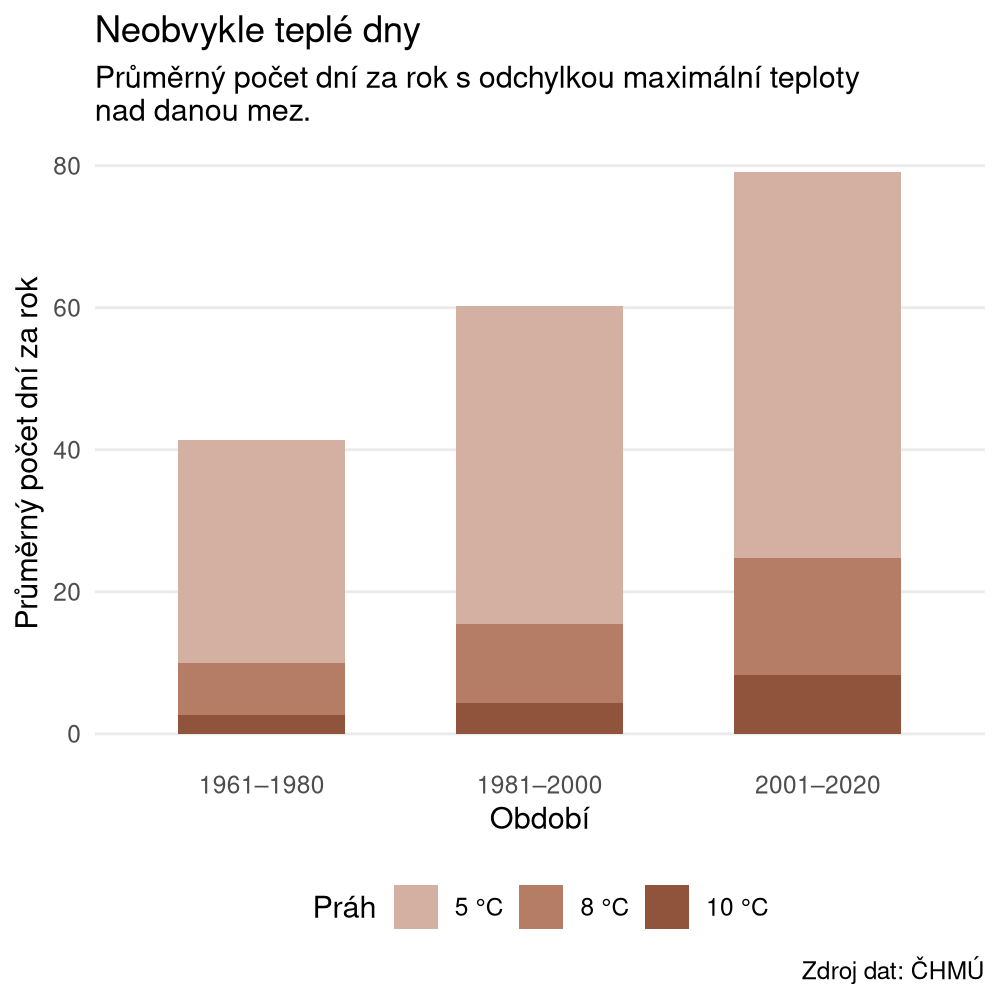

In [6]:
thresholds <- c(5, 8, 10)

options(repr.plot.width = 5, repr.plot.height = 5)
filter(daily_anomalies, station_id == "B2BTUR01") |>
  mutate(threshold = cut(anomaly_max, c(thresholds, Inf))) |>
  na.omit() |>
  group_by(period, threshold) |>
  summarise(count_per_year = n() / 20,
            .groups = "drop") |>
  ggplot(aes(period, count_per_year)) +
  geom_col(aes(fill = threshold), width = .6) +
  scale_fill_manual("Práh",
                    labels = paste(thresholds, "°C"),
                    values = c("#d3b0a2", "#b57d66", "#8f543b")) +
  labs(x        = "Období",
       y        = "Průměrný počet dní za rok",
       title    = "Neobvykle teplé dny",
       subtitle = "Průměrný počet dní za rok s odchylkou maximální teploty\nnad danou mez.",
       caption  = "Zdroj dat: ČHMÚ") +
  theme(legend.position    = "bottom",
        panel.grid.major.x = element_blank(),
        panel.grid.minor   = element_blank())

## Chladné dny

Následující graf ukazuje pokles počtu neobvykle chladných dní na příkladu stanice Brno-Tuřany.

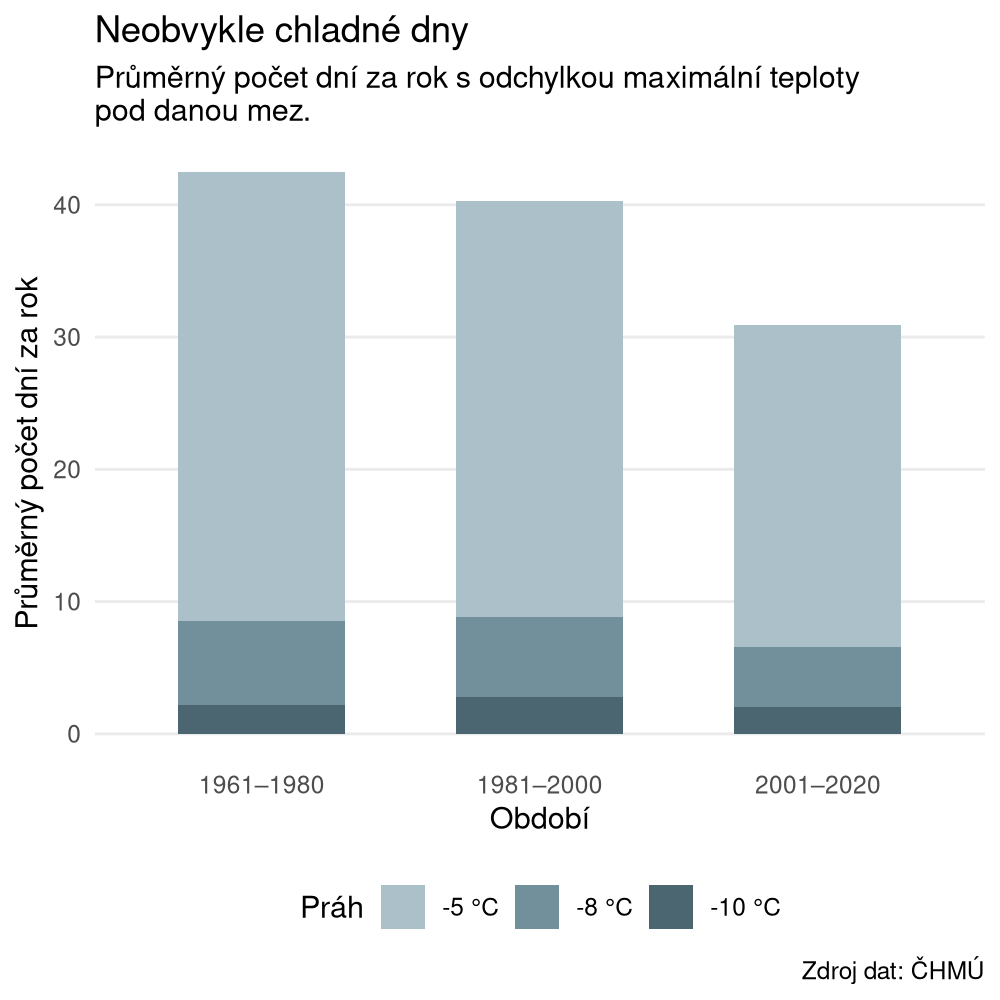

In [7]:
thresholds <- c(-10, -8, -5)

options(repr.plot.width = 5, repr.plot.height = 5)
filter(daily_anomalies, station_id == "B2BTUR01") |>
  mutate(threshold = cut(anomaly_max, c(-Inf, thresholds), right = FALSE) |> fct_rev()) |>
  na.omit() |>
  group_by(period, threshold) |>
  summarise(count_per_year = n() / 20,
            .groups = "drop") |>
  ggplot(aes(period, count_per_year)) +
  geom_col(aes(fill = threshold), width = .6) +
  scale_fill_manual("Práh",
                    labels = paste(rev(thresholds), "°C"),
                    values = c("#abc0c8", "#72909c", "#4c6671")) +
  labs(x        = "Období",
       y        = "Průměrný počet dní za rok",
       title    = "Neobvykle chladné dny",
       subtitle = "Průměrný počet dní za rok s odchylkou maximální teploty\npod danou mez.",
       caption  = "Zdroj dat: ČHMÚ") +
  theme(legend.position    = "bottom",
        panel.grid.major.x = element_blank(),
        panel.grid.minor   = element_blank())


## Posouvající se histogram


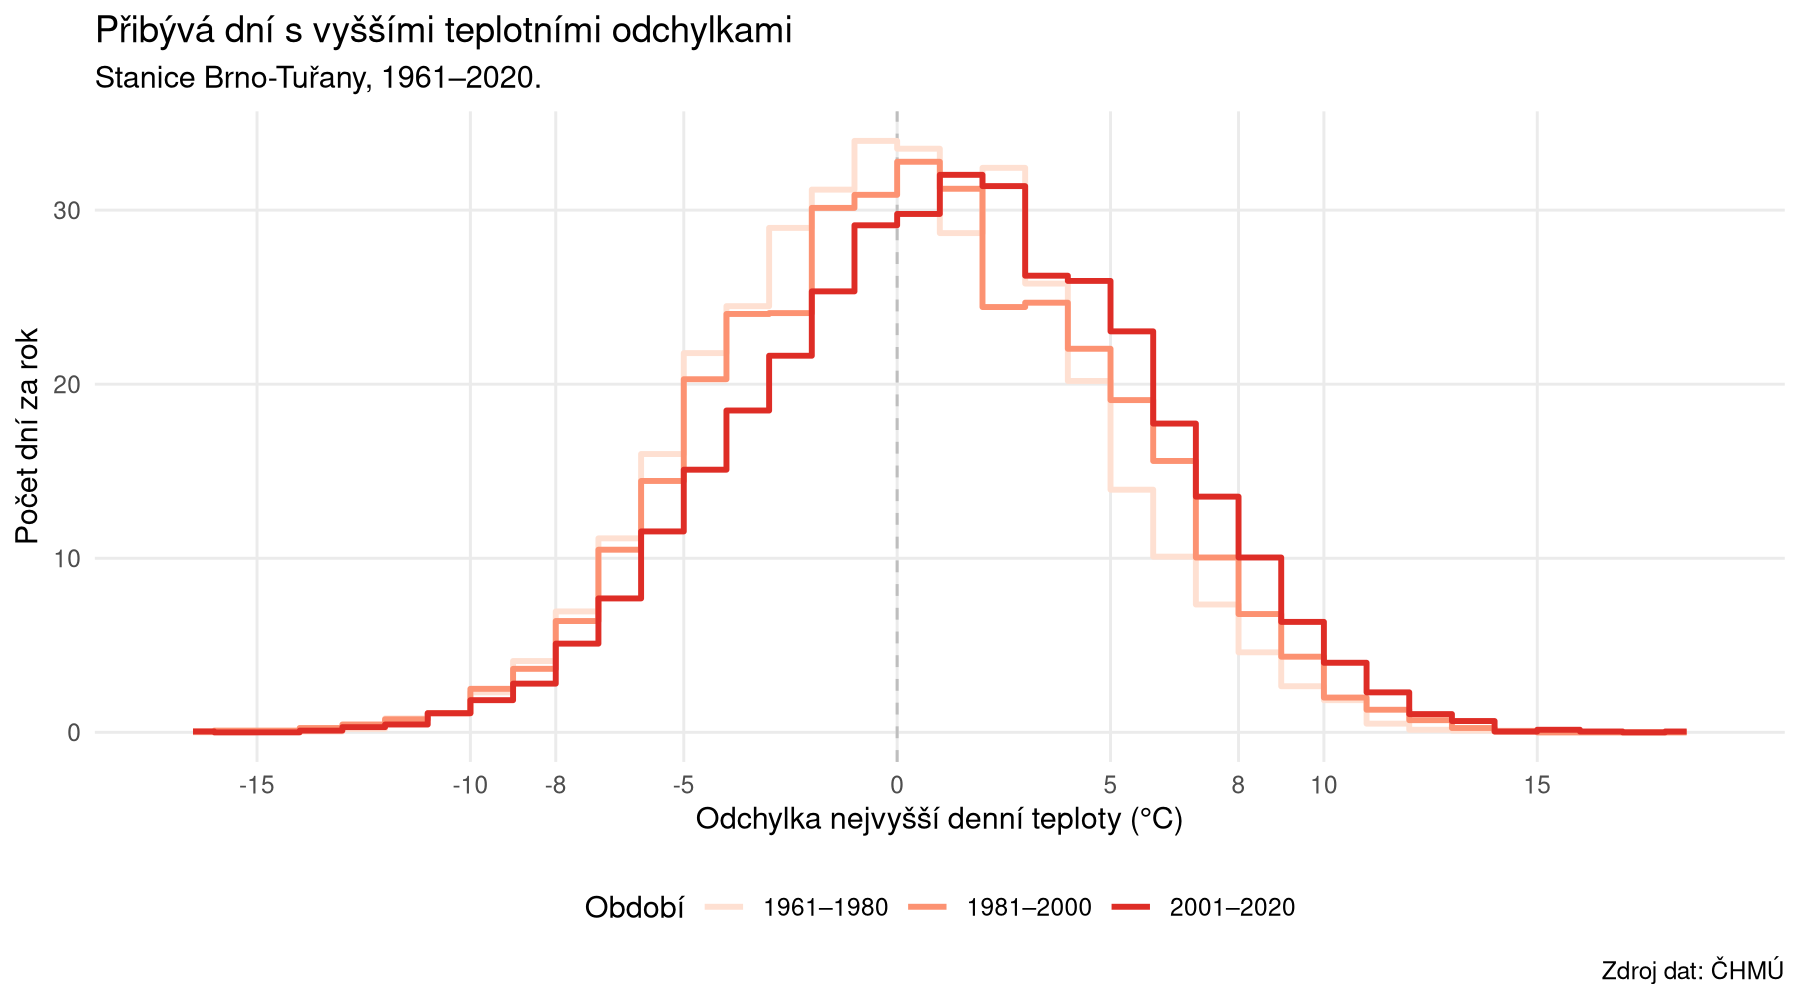

In [43]:
binwidth <- 1
breaks <- c(5, 8, 10, 15)

options(repr.plot.width = 9, repr.plot.height = 5)
filter(daily_anomalies, station_id == "B2BTUR01") |>
  ggplot(aes(anomaly_max)) +
  geom_vline(xintercept = 0, linetype = "dashed", colour = "grey") +
  stat_bin(aes(colour = period,
               y      = after_stat(density) * 365 * binwidth),
           geom      = "step",
           boundary  = 0,
           binwidth  = binwidth,
           linewidth = 1,
           direction = "mid",
           position  = "identity") +
  scale_colour_brewer("Období", palette = "Reds") +
  scale_x_continuous("Odchylka nejvyšší denní teploty (°C)",
                     breaks = c(rev(-breaks), 0, breaks)) +
  labs(y        = "Počet dní za rok",
       title    = "Přibývá dní s vyššími teplotními odchylkami",
       subtitle = glue::glue("Stanice Brno-Tuřany, {data_period[1]}–{data_period[2]}."),
       caption  = "Zdroj dat: ČHMÚ") +
  theme(legend.position  = "bottom",
        panel.grid.minor = element_blank())

Průměr odchylek v poslední dvacetiletce se oproti referenčnímu období zvýšil zhruba o 1,3 °C.

In [45]:
filter(daily_anomalies, station_id == "B2BTUR01") |>
  group_by(period) |>
  summarise(mean_anomaly = round(mean(anomaly_max), 2))

period,mean_anomaly
<fct>,<dbl>
1961–1980,0.00
1981–2000,0.43
2001–2020,1.31


## Tabulky

Tabulka počtu dní za rok s odchylkou pod/nad danou mez (±5 nebo ±10 °C):

In [18]:
filter(daily_anomalies, station_id == "B2BTUR01") |>
  pivot_longer(starts_with("anomaly_"),
               names_to  = "series",
               values_to = "anomaly") |>
  select(-(normal_avg:normal_min)) |>
  mutate(series = case_when(series == "anomaly_avg" ~ "Průměr",
                            series == "anomaly_max" ~ "Maximum",
                            series == "anomaly_min" ~ "Minimum")) |>
  split(~ series) |>
  map_df(~ group_by(.x, period) |>
           summarise(period  = first(period),
                     years   = unique(year) |> length(),
                     `< −10` = sum(anomaly < -10) / years,
                     `< −5`  = sum(anomaly <  -5) / years,
                     `> +5`  = sum(anomaly >   5) / years,
                     `> +10` = sum(anomaly >  10) / years),
         .id = "series") |>
  select(-years) |>
  group_by(series) |>
  gt::gt() |>
  gt::tab_header("Průměrný počet dní za rok s odchylkou pod/nad danou mez",
                 "Stanice: Brno-Tuřany") |>
  gt::cols_label(period = "Období") |>
  gt::fmt_number(columns = 3:6, decimals = 1) |>
  gt:::as.tags.gt_tbl()

Shiny tags cannot be represented in plain text (need html)

Tabulka podílu dní s odchylkou nejvyšší teploty v daném intervalu (±5, ±8 nebo ±10 °C):

In [13]:
thresholds <- c(5, 8, 10)

group_split(daily_anomalies, station_id, period) |>
  map_dfr(function(df) {
    map_dfr(thresholds,
            ~ summarise(df,
                        station_id = first(station_id),
                        period     = first(period),
                        threshold  = .x,
                        mid_prop   = mean(-.x < anomaly_max & anomaly_max < .x)))
  }) |>
  mutate(threshold = ordered(threshold,
                             levels = thresholds,
                             labels = glue::glue("(−{thresholds}, +{thresholds} °C)"))) |>
  pivot_wider(names_from = threshold, values_from = mid_prop) |>
  group_by(station_id) |>
  gt::gt() |>
  gt::tab_header("Podíl dní s odchylkou v daném intervalu") |>
  gt::cols_label(period = "Období") |>
  gt::fmt_percent(columns = 3:5, decimals = 1, pattern = "{x} ") |>
  gt:::as.tags.gt_tbl()

Shiny tags cannot be represented in plain text (need html)

In [30]:
thresholds <- c(-10, -5, 5, 10)

group_split(daily_anomalies, station_id, period) |>
  map_dfr(function(df) {
    map_dfr(thresholds,
            ~ summarise(df,
                        station_id = first(station_id),
                        period     = first(period),
                        threshold  = .x,
                        # Count days *below* the threshold for *negative* numbers
                        # and days *above* for *positive* numbers.
                        count      = if_else(.x < 0,
                                             sum(anomaly_max < .x),
                                             sum(anomaly_max > .x)) / 20))
  }) |>
  mutate(threshold = ordered(threshold,
                             levels = thresholds,
                             labels = if_else(thresholds < 0,
                                              glue::glue("< {thresholds} °C"),
                                              glue::glue("> +{thresholds} °C")))) |>
  pivot_wider(names_from = threshold, values_from = count) |>
  group_by(station_id) |>
  gt::gt() |>
  gt::tab_header("Počet dní s odchylkou pod/nad danou mez") |>
  gt::cols_label(period = "Období") |>
  gt::fmt_number(columns = -period, decimals = 1) |>
  gt:::as.tags.gt_tbl()

Shiny tags cannot be represented in plain text (need html)

## Dodatek: Otázky

### Jak souvisí nejnižší a nejvyšší denní teploty s průměrnou denní teplotou?

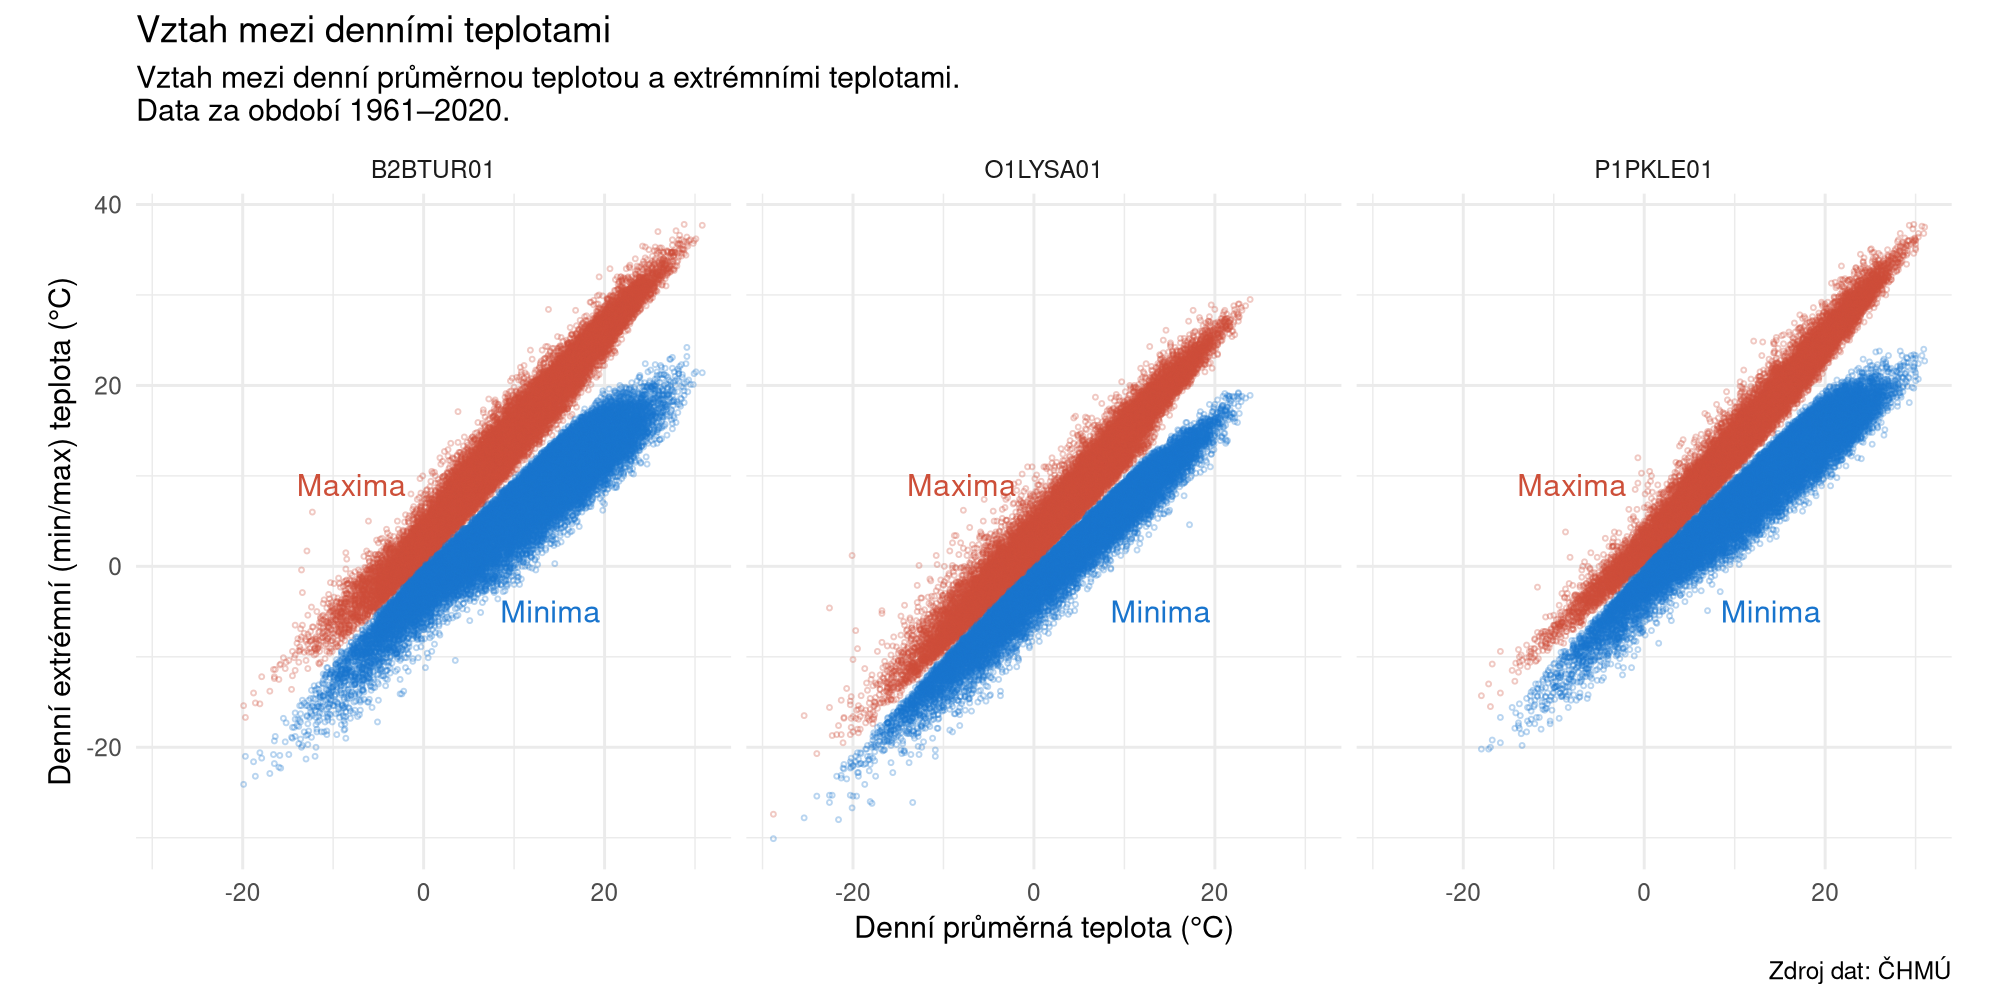

In [15]:
options(repr.plot.width = 10, repr.plot.height = 5)
filter(daily_weather, station_id %in% c("B2BTUR01", "O1LYSA01", "P1PKLE01")) |>
  ggplot(aes(x = tavg)) +
  geom_point(aes(y = tmax, colour = "max"),
             shape = 1,
             size  = .5) +
  geom_point(aes(y = tmin, colour = "min"),
             shape = 1,
             size  = .5) +
  annotate("text", 14, -5, label = "Minima", colour = COLOUR_TMIN) +
  annotate("text", -8, 9, label = "Maxima", colour = COLOUR_TMAX) +
  scale_colour_manual(values = adjustcolor(c(COLOUR_TMAX, COLOUR_TMIN), .3),
                      guide  = "none") +
  coord_fixed() +
  facet_wrap(vars(station_id)) +
  labs(title    = "Vztah mezi denními teplotami",
       subtitle = glue::glue("Vztah mezi denní průměrnou teplotou a extrémními teplotami.\n",
                             "Data za období {data_period[1]}–{data_period[2]}."),
       caption  = "Zdroj dat: ČHMÚ",
       x        = "Denní průměrná teplota (°C)",
       y        = "Denní extrémní (min/max) teplota (°C)")

In [16]:
# Tabulka korelací s průměrnou teplotou.
group_split(daily_weather, station_id) |>
  map_dfr(function(df) {
    select(df, tavg, tmax, tmin) |>
      as.matrix() |>
      cor() |> round(2) |>
      as_tibble() |>
      slice(1) |>
      mutate(station_id = first(df$station_id), .before = 1)
  })

station_id,tavg,tmax,tmin
<chr>,<dbl>,<dbl>,<dbl>
B2BTUR01,1,0.98,0.95
O1LYSA01,1,0.98,0.98
P1PKLE01,1,0.99,0.96
P1PRUZ01,1,0.98,0.95
P3PRIB01,1,0.98,0.94
U2LIBC01,1,0.98,0.94


Pearsonova korelace mezi denní průměrnou a maximální teplotou v Brně-Tuřanech je 0,98. Korelace mezi denní průměrnou a minimální teplotou je 0,95.

### Jak souvisí odchylka nejvyšší a nejnižší denní teploty s odchylkou průměrné denní teploty?

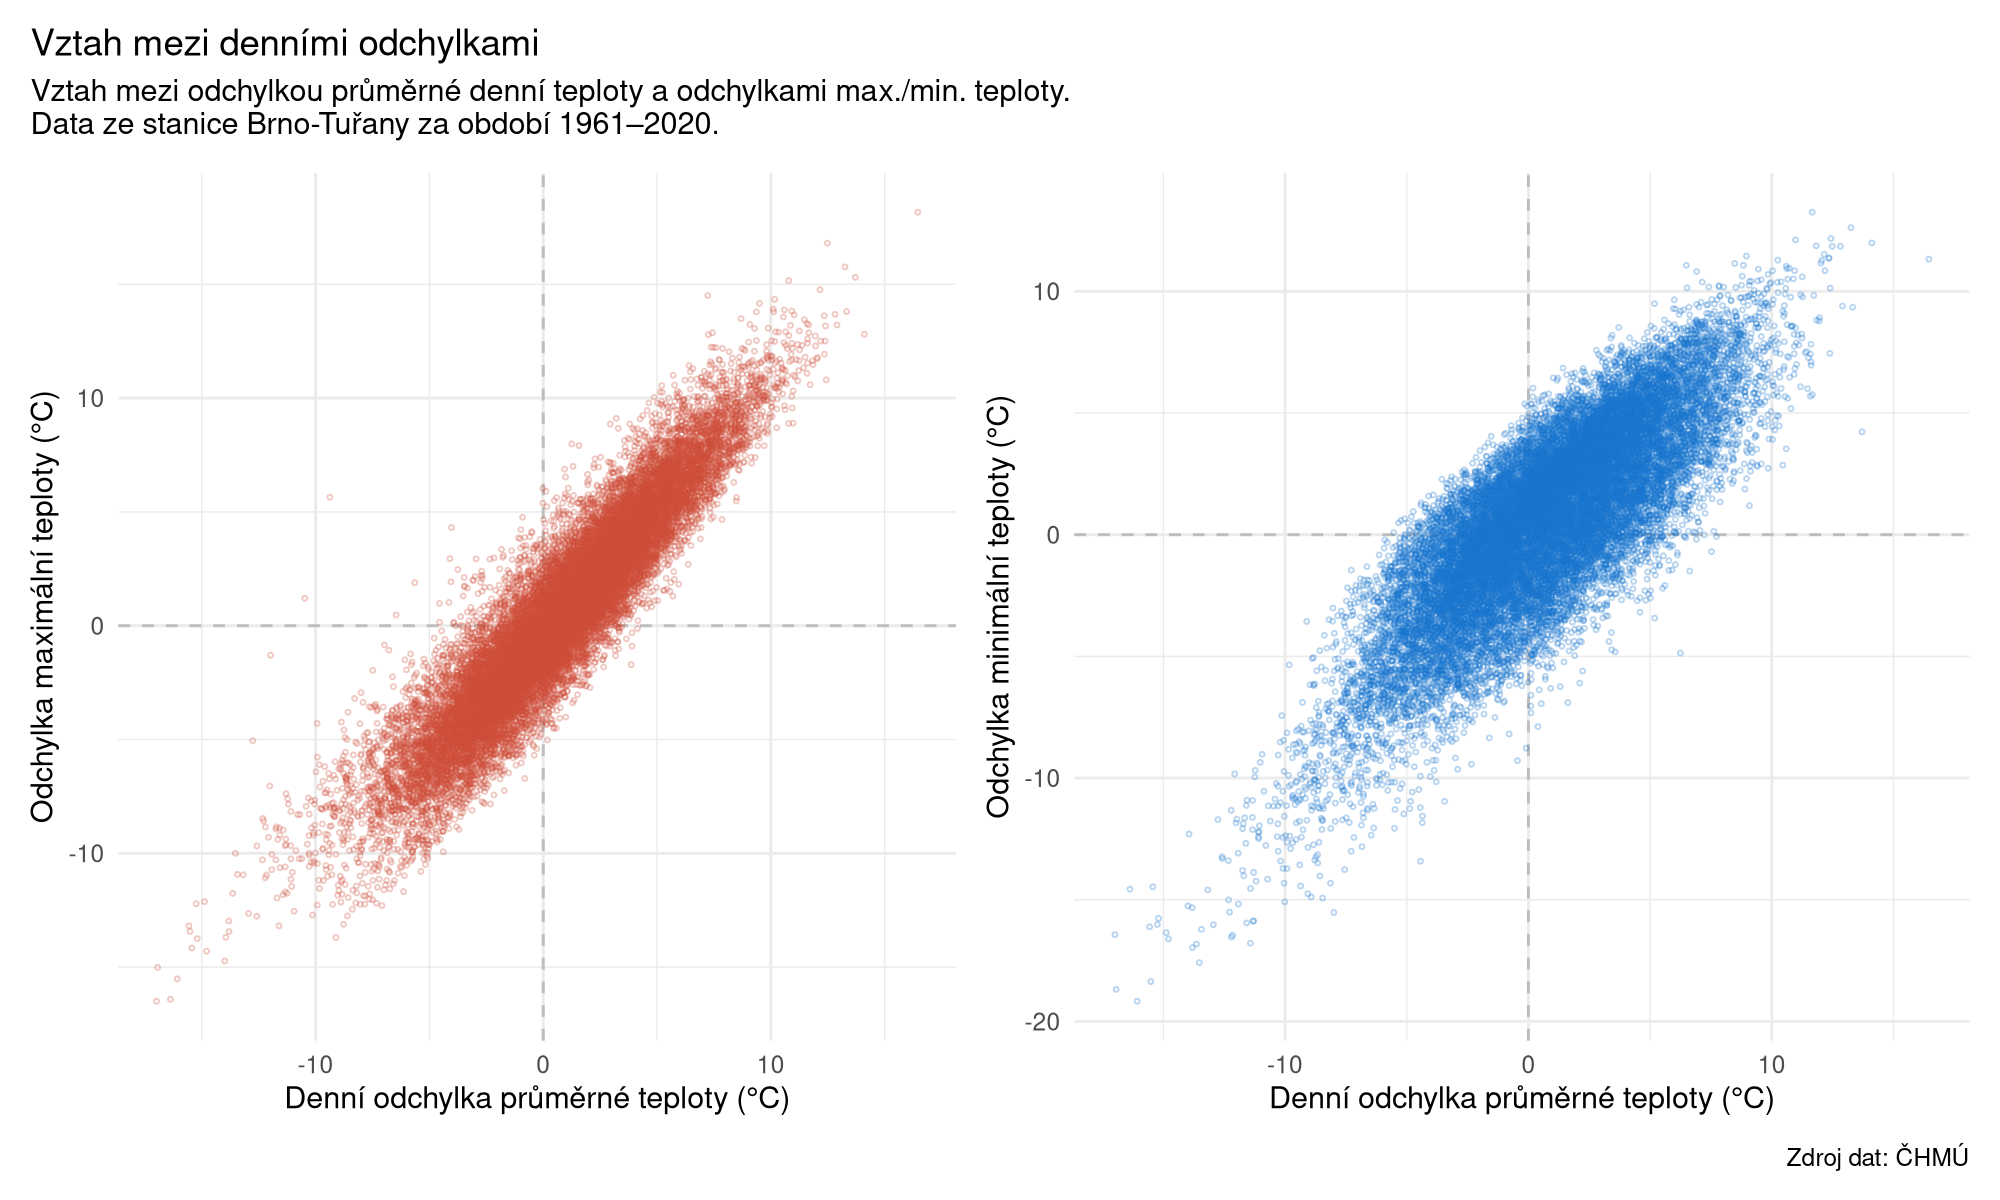

In [17]:
anomalies_turany <- filter(daily_anomalies, station_id == "B2BTUR01")

p_anom_corr_max <- ggplot(anomalies_turany, aes(anomaly_avg, anomaly_max)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey") +
  geom_point(shape  = 1,
             size   = .5,
             colour = adjustcolor(COLOUR_TMAX, .3)) +
  coord_fixed() +
  labs(x = "Denní odchylka průměrné teploty (°C)",
       y = "Odchylka maximální teploty (°C)")

p_anom_corr_min <- ggplot(anomalies_turany, aes(anomaly_avg, anomaly_min)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey") +
  geom_point(shape  = 1,
             size   = .5,
             colour = adjustcolor(COLOUR_TMIN, .3)) +
  coord_fixed() +
  labs(x = "Denní odchylka průměrné teploty (°C)",
       y = "Odchylka minimální teploty (°C)")

options(repr.plot.width = 10, repr.plot.height = 6)
p_anom_corr_max + p_anom_corr_min +
  plot_annotation(
    title    = "Vztah mezi denními odchylkami",
    subtitle = glue::glue("Vztah mezi odchylkou průměrné denní teploty a odchylkami max./min. teploty.\n",
                          "Data ze stanice Brno-Tuřany za období {data_period[1]}–{data_period[2]}."),
    caption  = "Zdroj dat: ČHMÚ")

In [ ]:
# Tabulka korelací s anomálií průměrné teploty.
group_split(daily_anomalies, station_id) |>
  map_dfr(function(df) {
    select(df, aavg = anomaly_avg, amax = anomaly_max, amin = anomaly_min) |>
      as.matrix() |>
      cor() |> round(2) |>
      as_tibble() |>
      slice(1) |>
      mutate(station_id = first(df$station_id), .before = 1)
  })

station_id,aavg,amax,amin
<chr>,<dbl>,<dbl>,<dbl>
B2BTUR01,1,0.93,0.81
O1LYSA01,1,0.94,0.94
P1PKLE01,1,0.95,0.86
P1PRUZ01,1,0.93,0.81
P3PRIB01,1,0.91,0.81
U2LIBC01,1,0.92,0.82


Pearsonova korelace mezi denní anomálií průměrné a maximální teploty v Brně-Tuřanech je 0,93. Korelace mezi denní anomálií průměrné a minimální teploty je 0,81.

### Jaký je vztah mezi teplotami na různých místech ČR?

Je teplotní odchylka dobře korelovaná na celém území ČR? Můžeme očekávat, že když je odchylka v Praze +10 °C, bude podobná i na Lysé hoře?

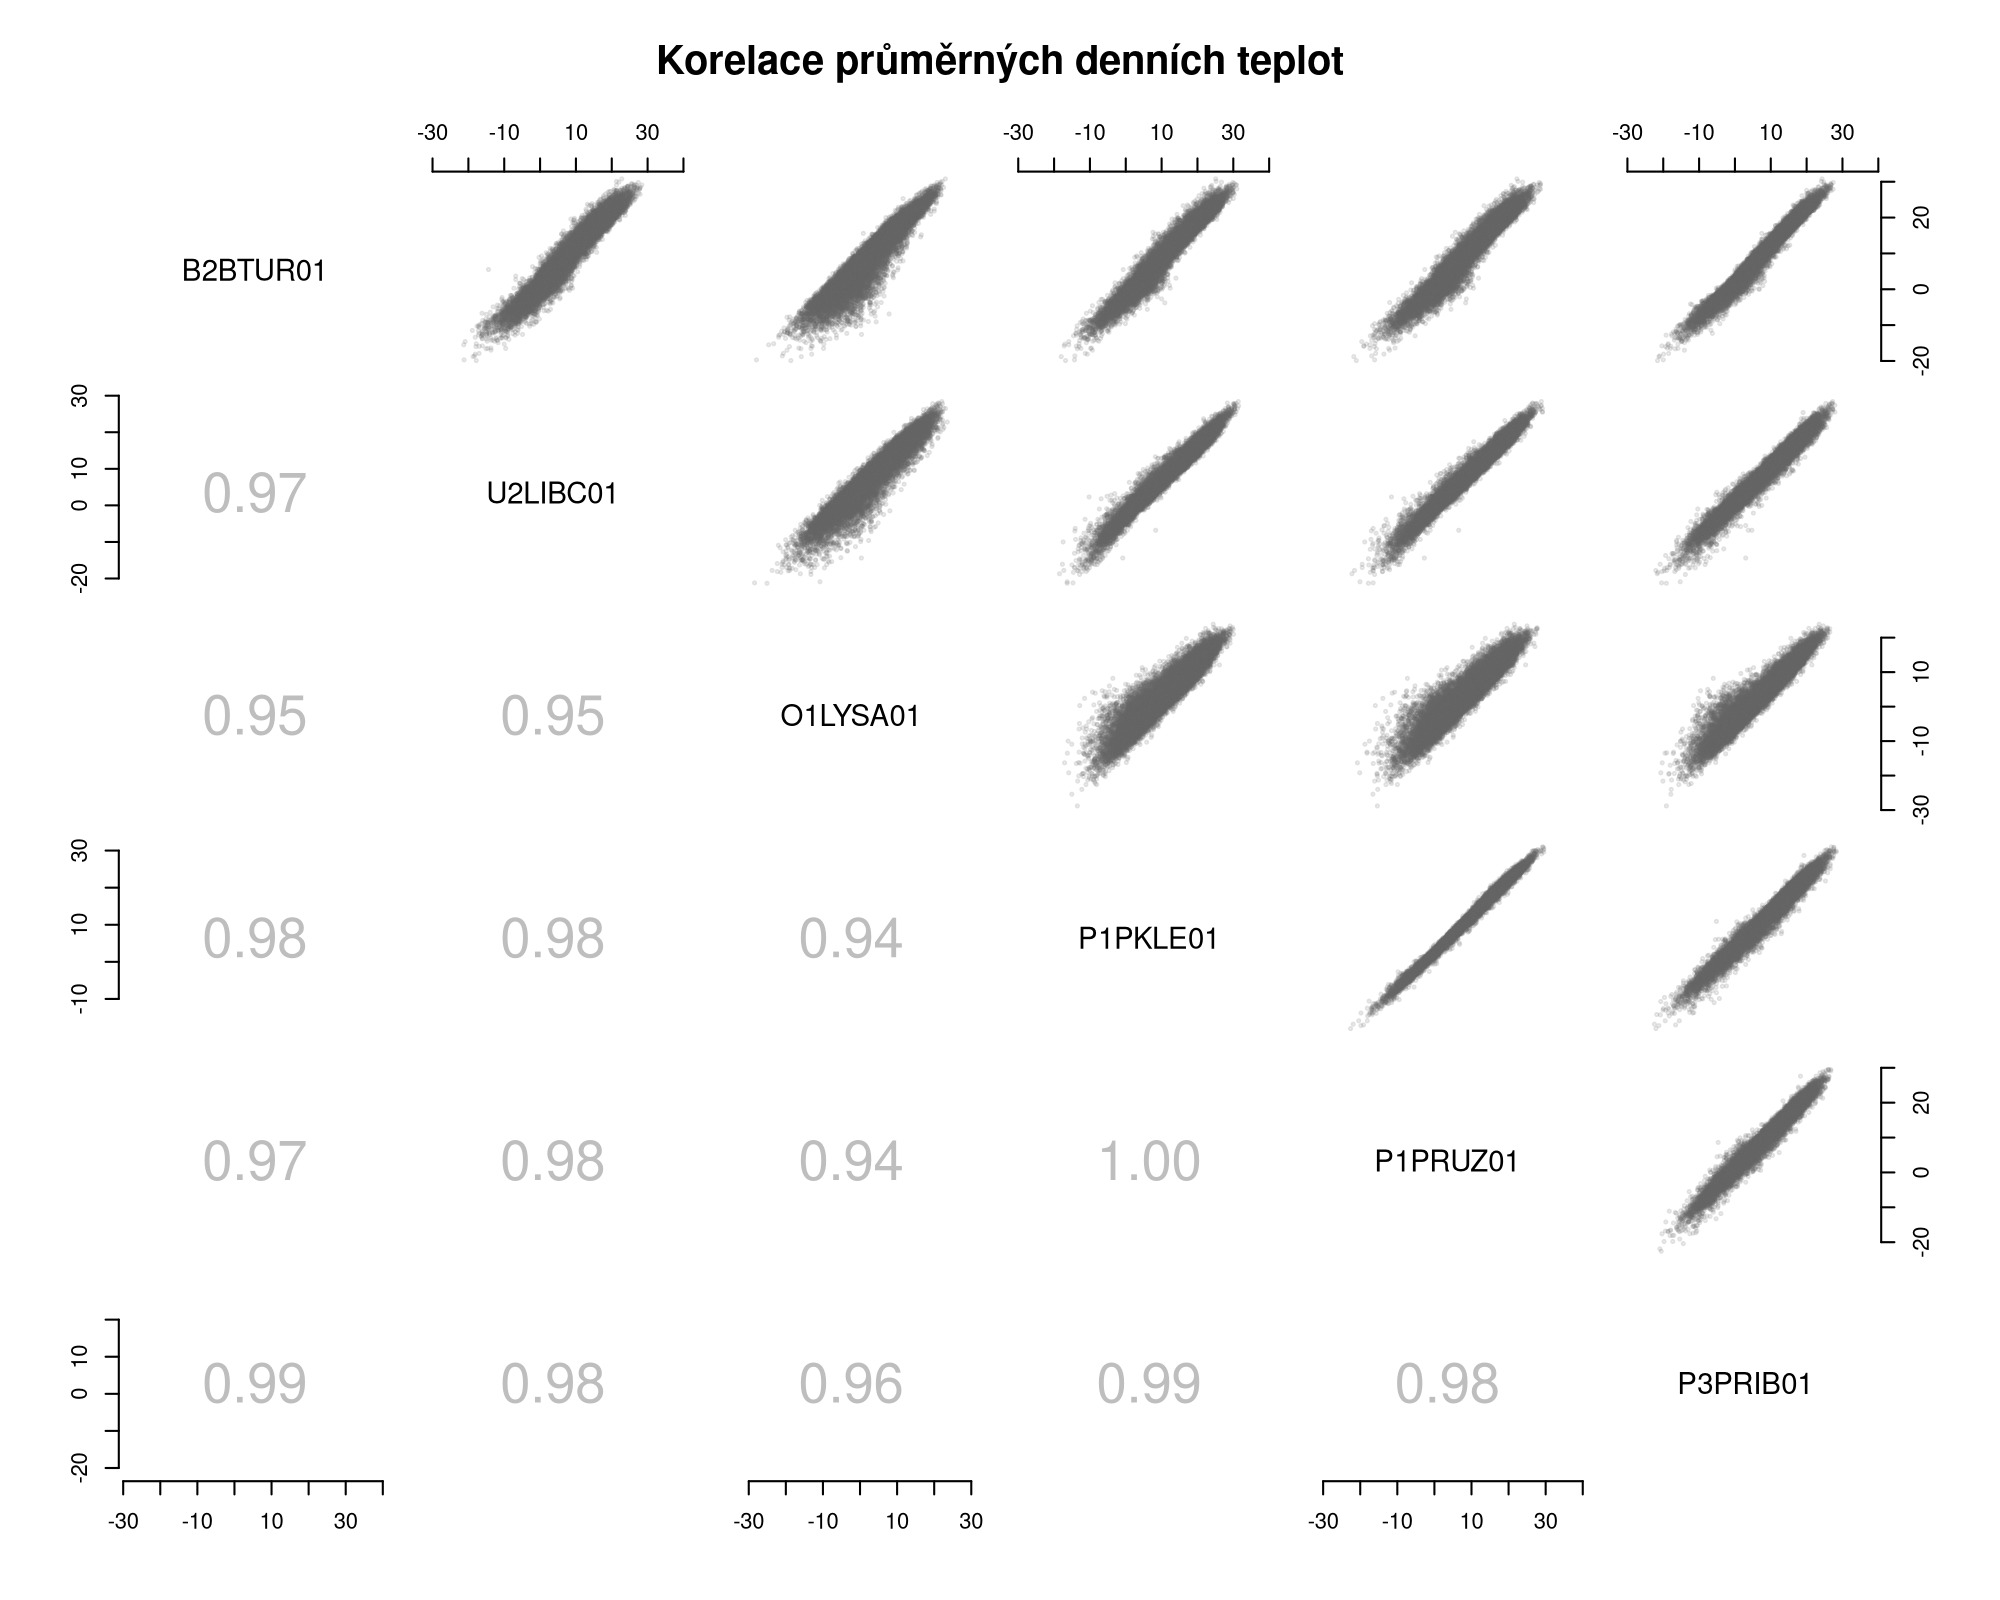

In [64]:
panel.cor <- function(x, y, ...) {
  par(usr = c(0, 1, 0, 1))
  r   <- abs(cor(x, y, "complete.obs"))
  txt <- format(c(r, .01), digits = 2)[1]
  cex <- .6 / strwidth(txt)
  text(.5, .5, txt, cex = cex, col = "grey")
}

options(repr.plot.width = 10, repr.plot.height = 8)
par(bty = "n")
select(daily_weather, station_id, year:day, tavg) |>
  pivot_wider(names_from = station_id, values_from = tavg) |>
  select(-(year:day)) |>
  pairs(col = adjustcolor(COLOUR_TAVG, .2), cex = .3, asp = 1,
        lower.panel = panel.cor, main = "Korelace průměrných denních teplot")

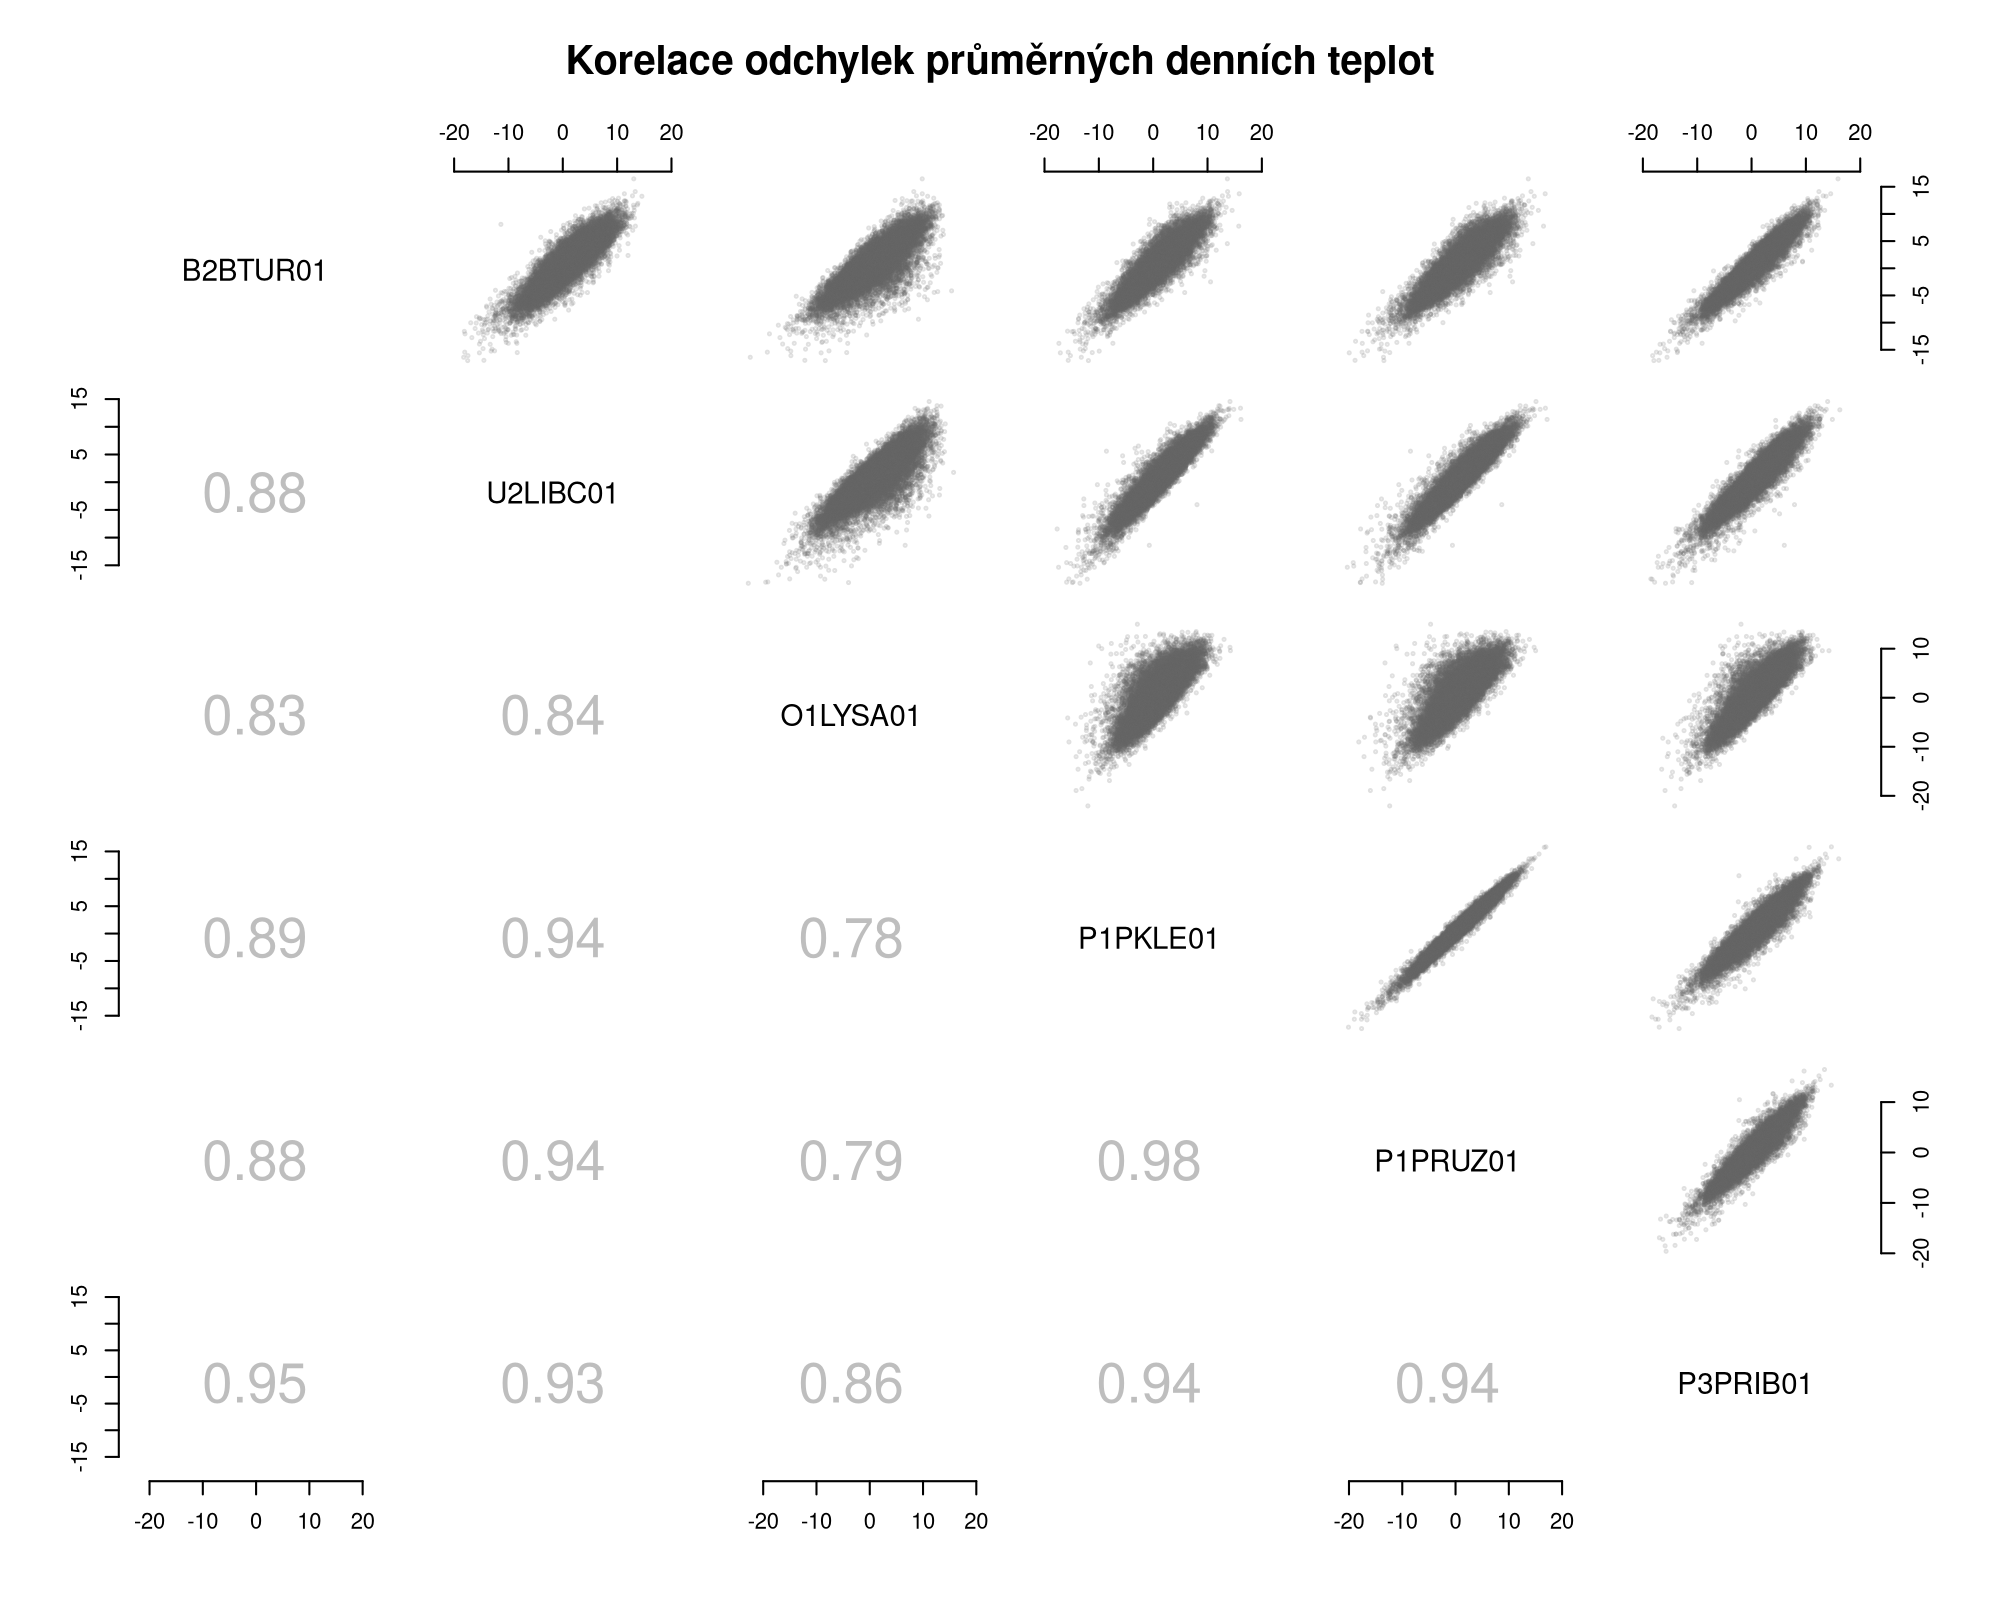

In [65]:
options(repr.plot.width = 10, repr.plot.height = 8)
par(bty = "n")
select(daily_anomalies, station_id, year:day, anomaly_avg) |>
  pivot_wider(names_from = station_id, values_from = anomaly_avg) |>
  select(-(year:day)) |>
  pairs(col = adjustcolor(COLOUR_TAVG, .2), cex = .3, asp = 1,
        lower.panel = panel.cor, main = "Korelace odchylek průměrných denních teplot")

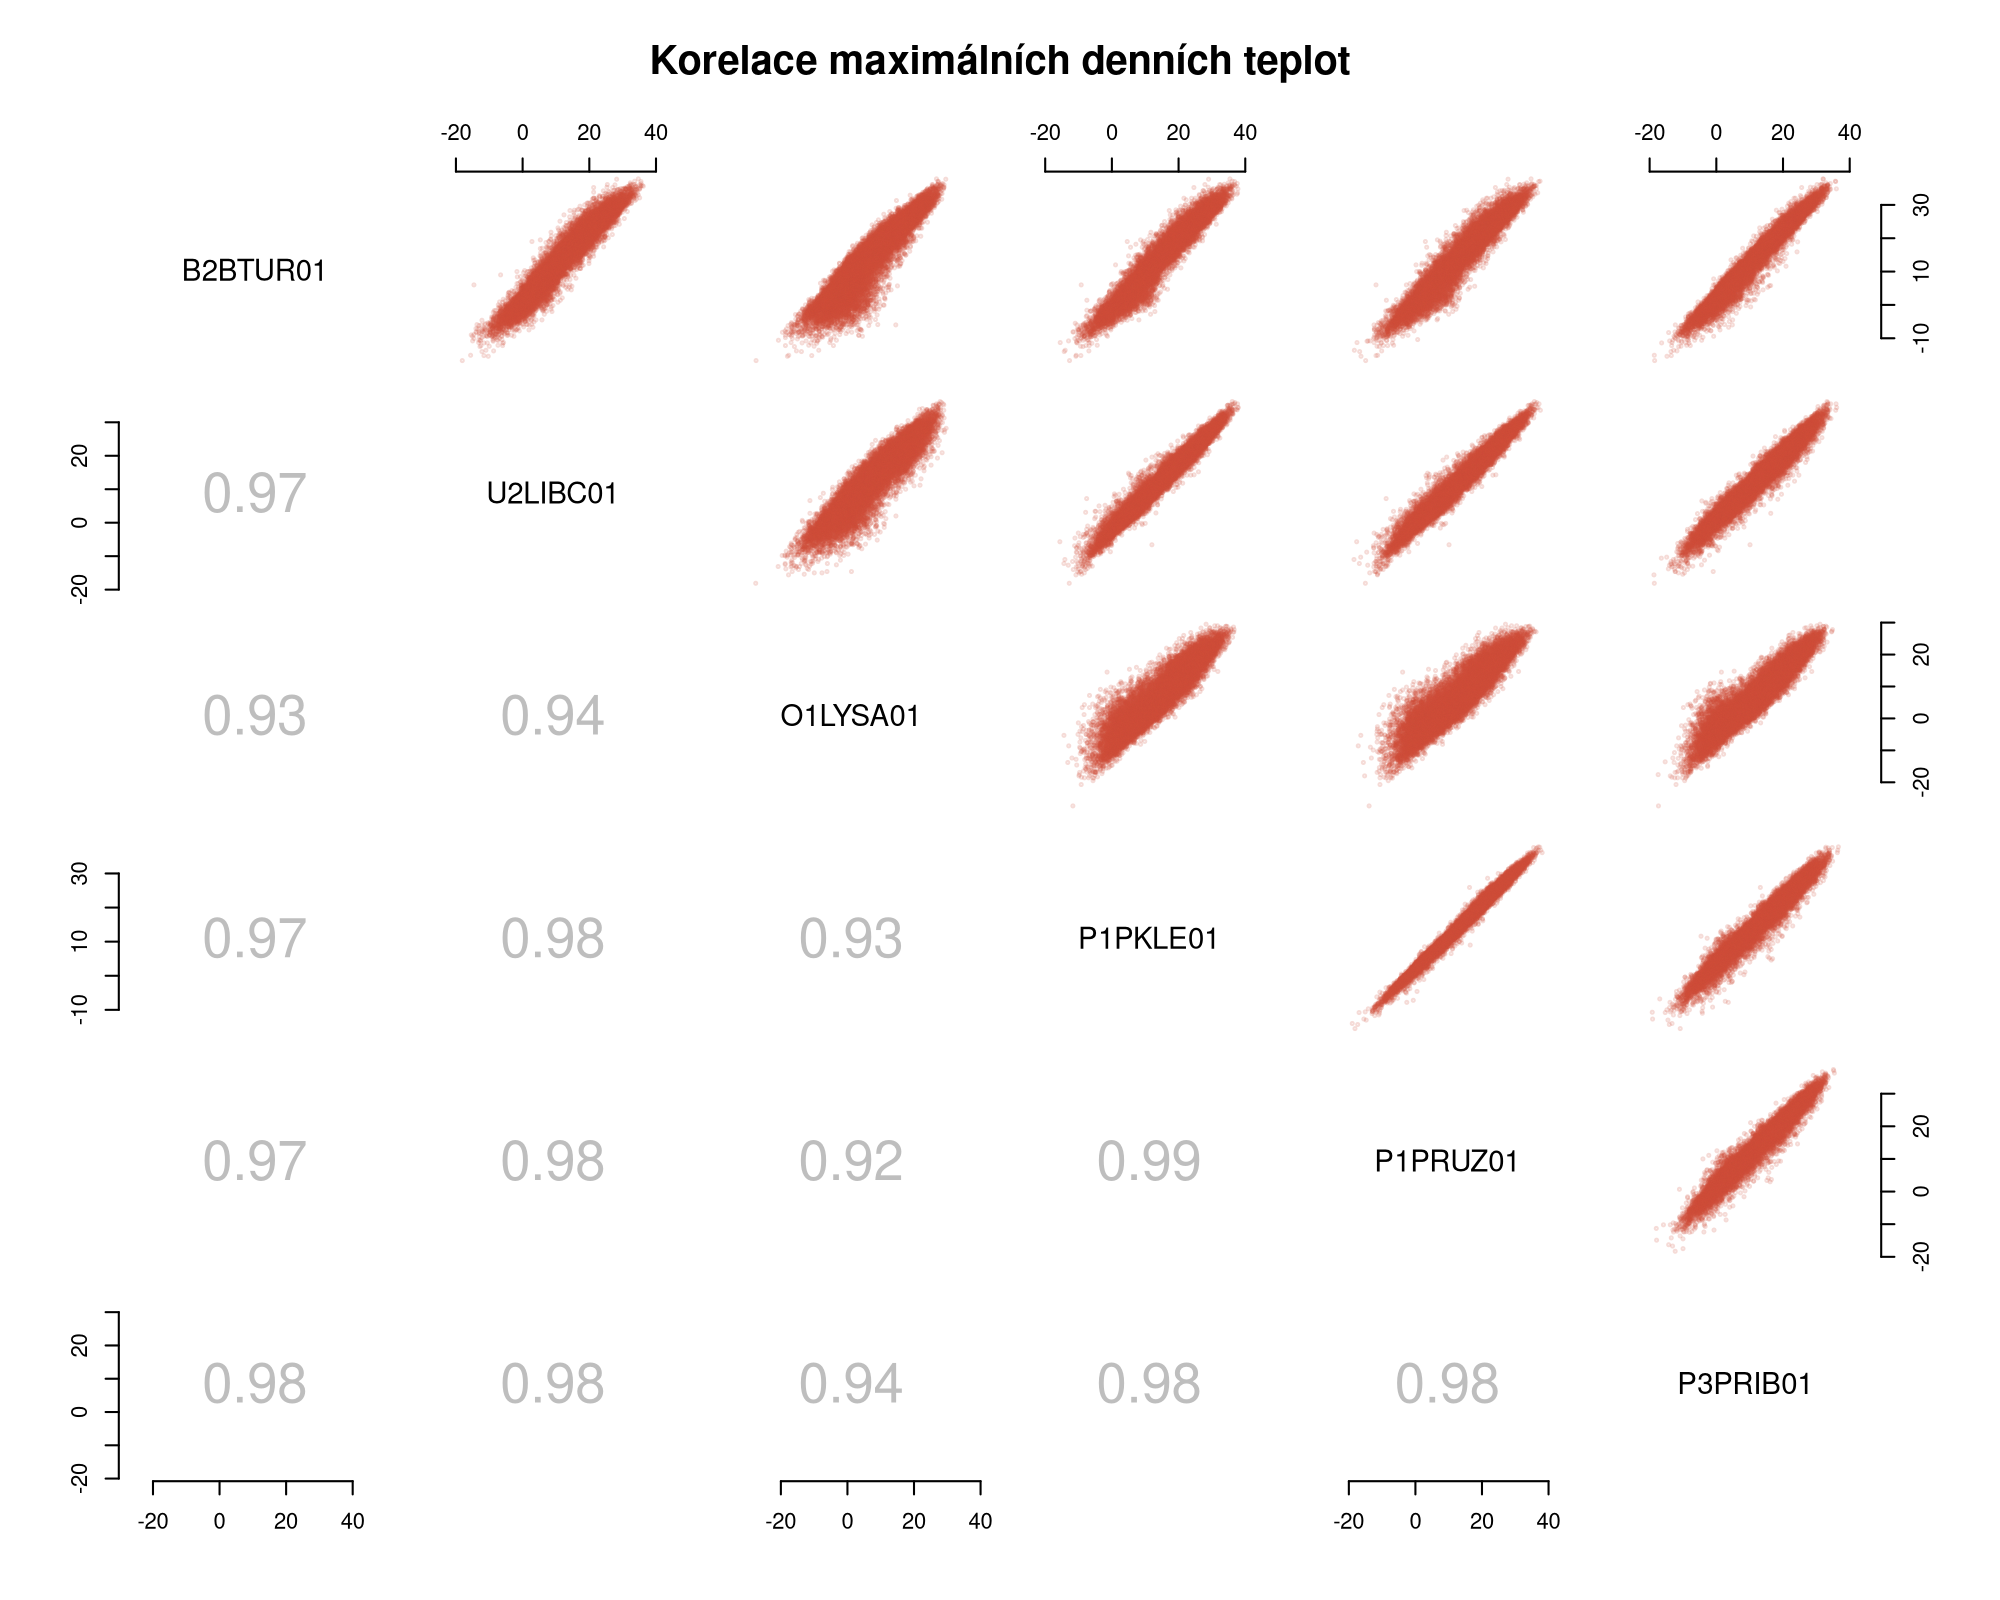

In [67]:
options(repr.plot.width = 10, repr.plot.height = 8)
par(bty = "n")
select(daily_weather, station_id, year:day, tmax) |>
  pivot_wider(names_from = station_id, values_from = tmax) |>
  select(-(year:day)) |>
  pairs(col = adjustcolor(COLOUR_TMAX, .2), cex = .3, asp = 1,
        lower.panel = panel.cor, main = "Korelace maximálních denních teplot")

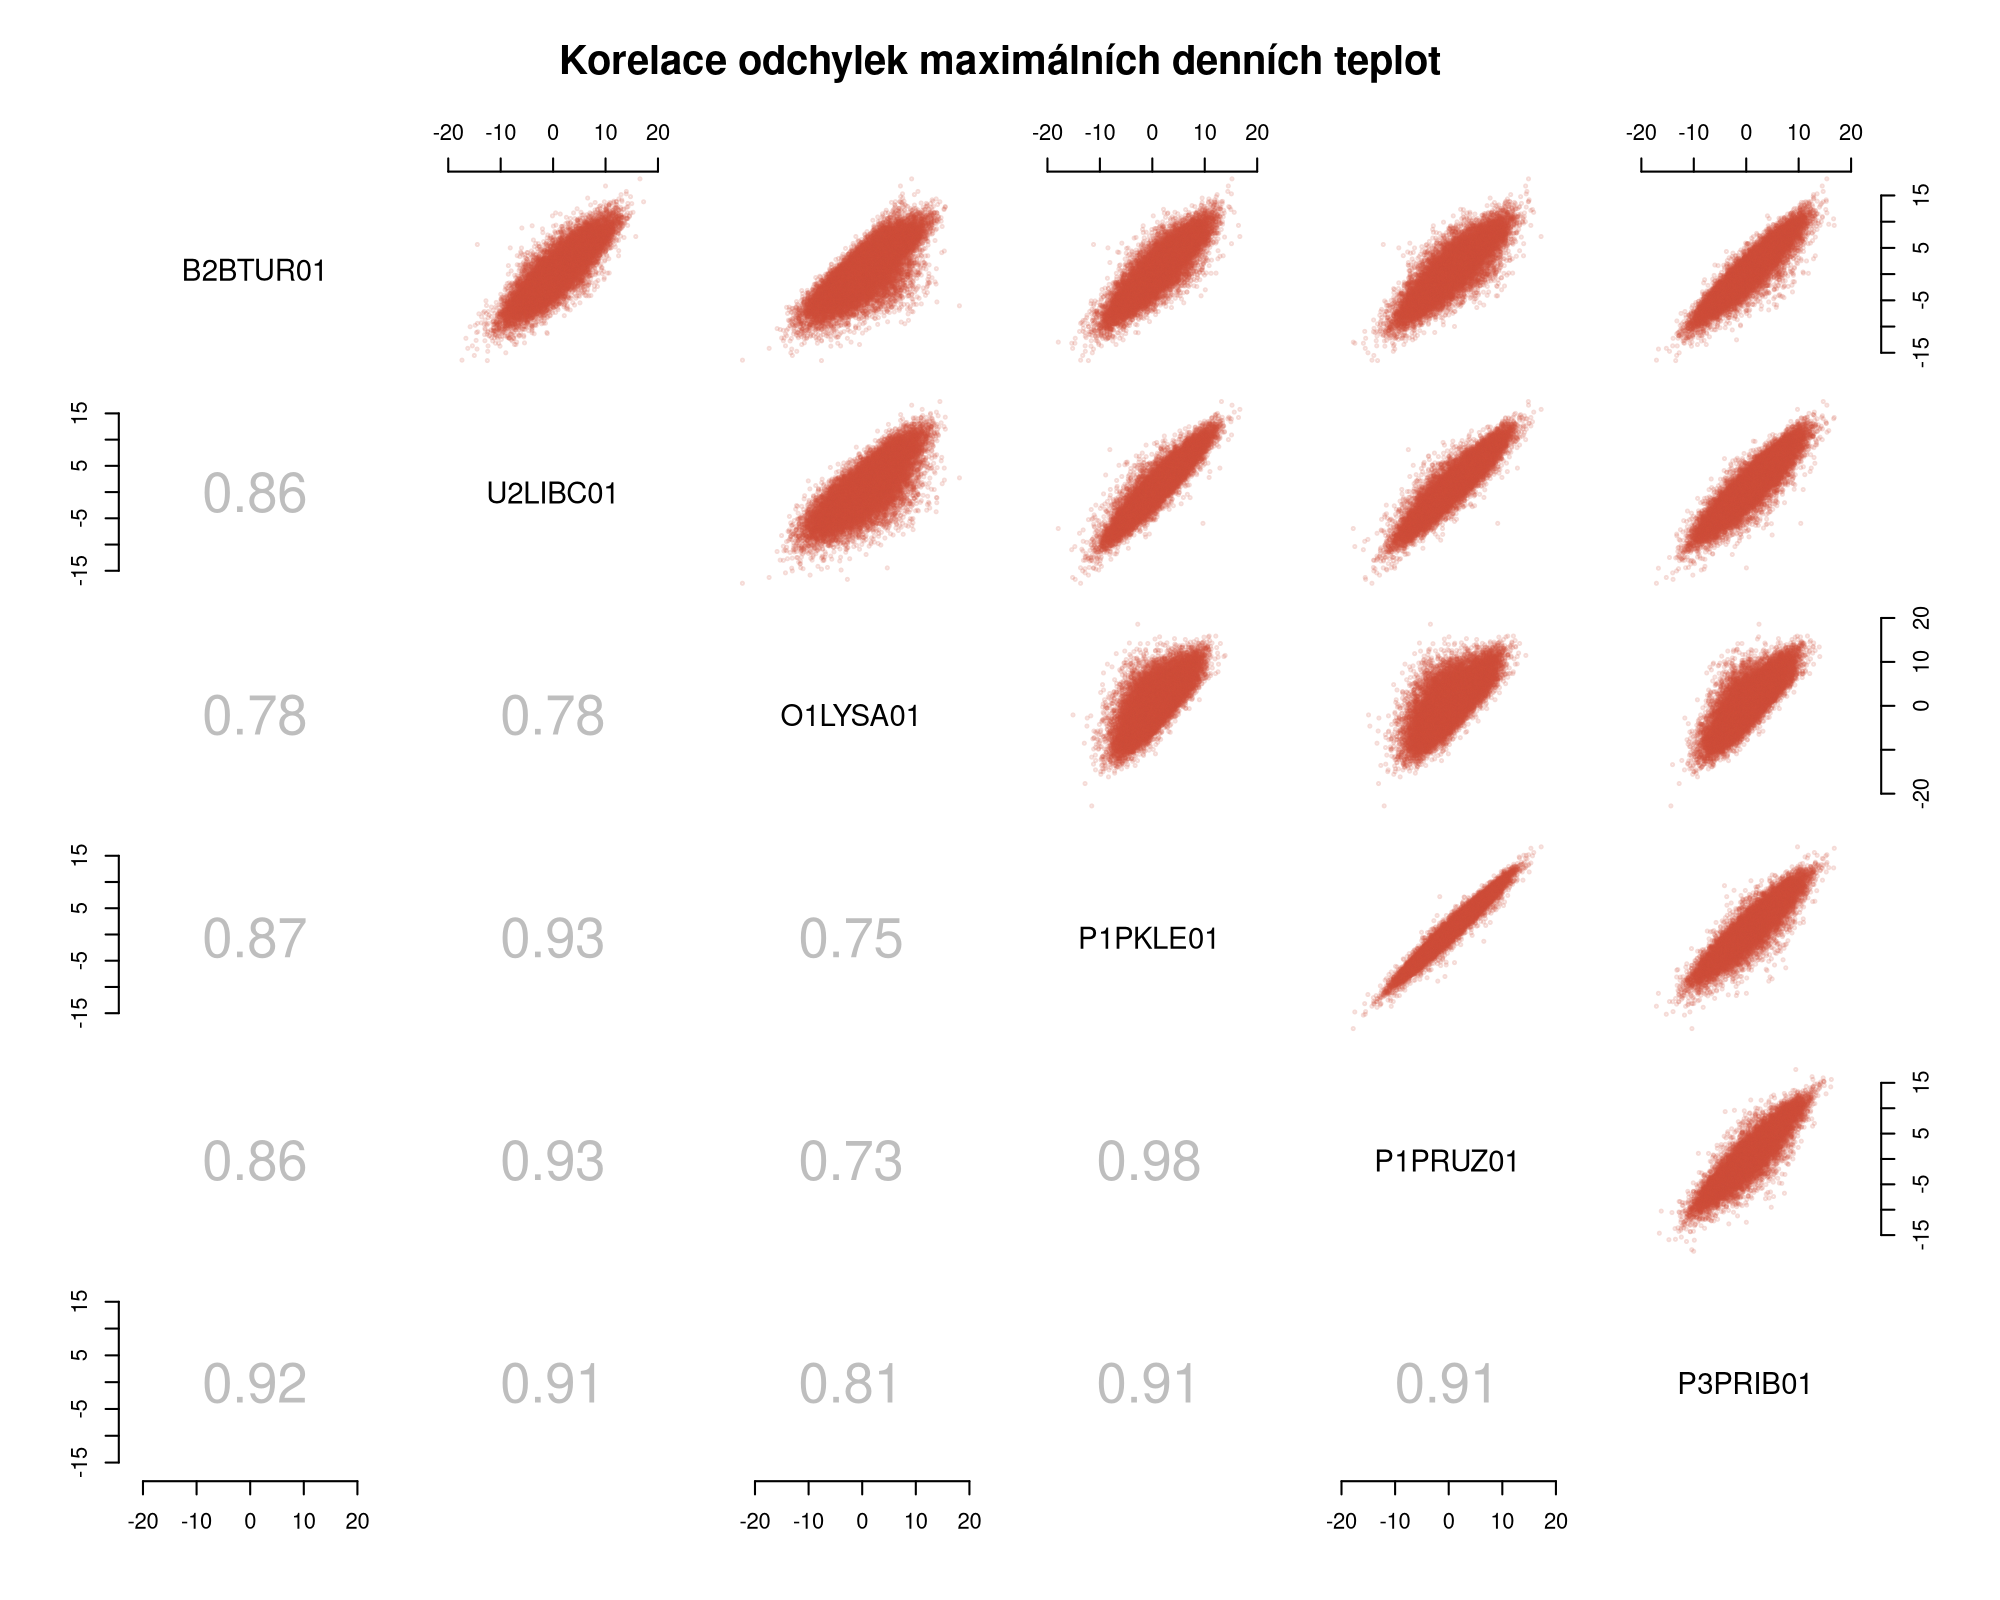

In [66]:
options(repr.plot.width = 10, repr.plot.height = 8)
par(bty = "n")
select(daily_anomalies, station_id, year:day, anomaly_max) |>
  pivot_wider(names_from = station_id, values_from = anomaly_max) |>
  select(-(year:day)) |>
  pairs(col = adjustcolor(COLOUR_TMAX, .2), cex = .3, asp = 1,
        lower.panel = panel.cor, main = "Korelace odchylek maximálních denních teplot")

### Jaká je variabilita počasí v průběhu roku?

Následující vizualizace zobrazuje varibilitu teplotních odchylek v průběhu roku. Zleva jsou postupně období 1961–1980, 1981–2000 a 2000–2020. Variabilita v zimních měsících je o něco větší.

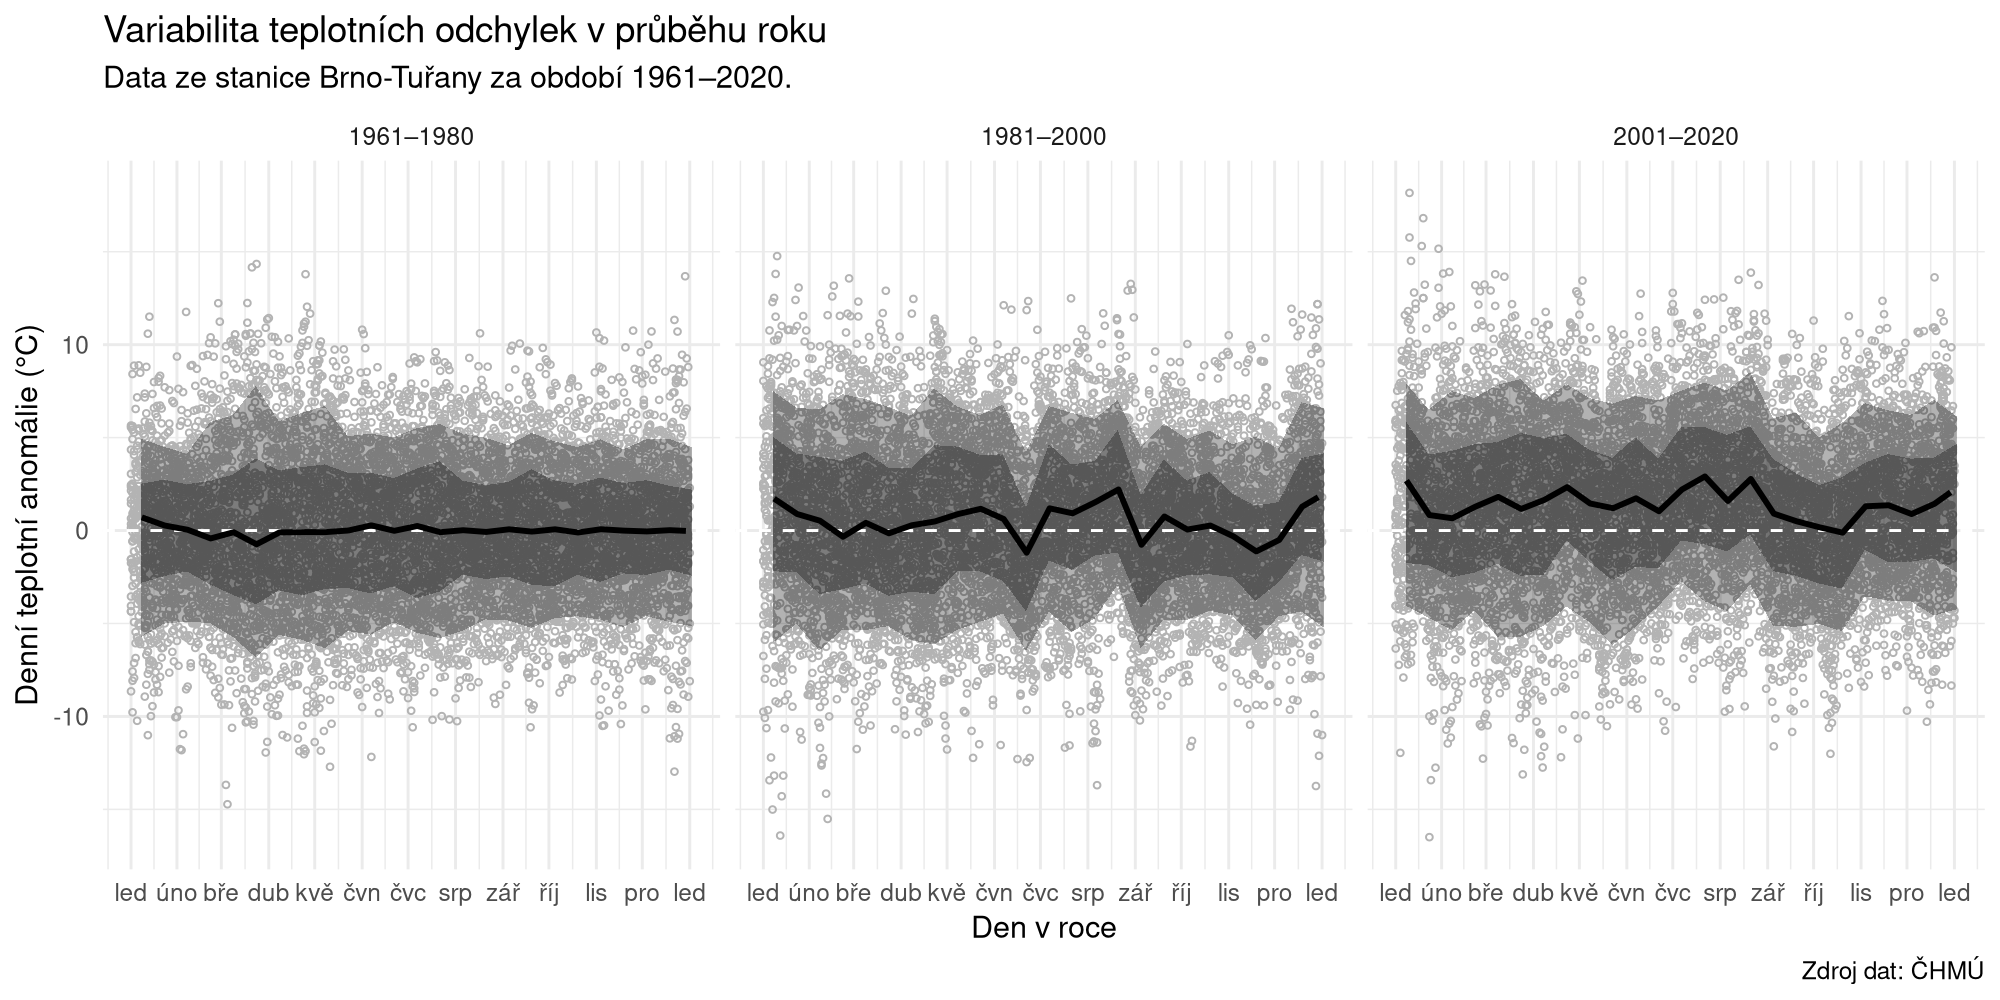

In [62]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(anomalies_turany, aes(ix, anomaly_max)) +
  # Body pro jednotlivá denní měření.
  geom_point(colour = "grey70", size = .8, shape = 1) +
  # Pruh pro 50% centrální kvantily – 15denní bins.
  stat_summary_bin(geom     = "ribbon",
                   fun.min  = ~ quantile(.x, .25),
                   fun.max  = ~ quantile(.x, .75),
                   binwidth = 15,
                   fill     = adjustcolor("black", .3)) +
  # Pruh pro 80% centrální kvantily – 15denní bins.
  stat_summary_bin(geom     = "ribbon",
                   fun.min  = ~ quantile(.x, .1),
                   fun.max  = ~ quantile(.x, .9),
                   binwidth = 15,
                   fill     = adjustcolor("black", .3)) +
  # Přerušovaná čára pro nulovou anomálii.
  geom_hline(yintercept = 0, linetype = "dashed", colour = "white") +
  # Černá čára pro medián anomálie v 15denním období.
  geom_line(data = ~ mutate(.x, bin = cut_interval(ix, length = 15)) |>
              group_by(period, bin) |>
              summarise(ix          = mean(range(ix)),
                        anomaly_max = median(anomaly_max),
                        .groups     = "drop"),
            linewidth = 1) +
  scale_x_continuous("Den v roce",
                     breaks = c(1, cumsum(month.len)),
                     labels = c(month.abb, month.abb[1])) +
  facet_grid(cols = vars(period)) +
  labs(title    = "Variabilita teplotních odchylek v průběhu roku",
       subtitle = glue::glue("Data ze stanice Brno-Tuřany za období {data_period[1]}–{data_period[2]}."),
       caption  = "Zdroj dat: ČHMÚ",
       y        = "Denní teplotní anomálie (°C)")